In [53]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

In [76]:
#Load the training data

energy = (pd.read_csv('GrapheneTrainingData061318_bias_12000.csv', header=None)*1000).round().astype(int)

energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]

col_names = ['deltaI', 'deltaR', 'scale_factor']+ energy_names + energy_names
data = pd.read_csv('GrapheneTrainingData061318_12000.csv', header = None, names = col_names, index_col = None)
data.head()

C:\Users\emory\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,deltaI,deltaR,scale_factor,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,...,E_482_mV.1,E_484_mV.1,E_486_mV.1,E_488_mV.1,E_490_mV.1,E_492_mV.1,E_494_mV.1,E_496_mV.1,E_498_mV.1,E_500_mV.1
0,0.81472,-0.14798,0.92540,0.63680,0.63079,0.63245,0.63219,0.62666,0.62470,0.62493,...,0.54618,0.54590,0.54652,0.54620,0.54594,0.54544,0.54529,0.54688,0.54630,0.54615
1,0.91338,-0.57749,0.91951,0.65701,0.65033,0.65127,0.65180,0.64309,0.64273,0.64005,...,0.50541,0.50527,0.50603,0.50545,0.50511,0.50491,0.50442,0.50512,0.50472,0.50424
2,0.27850,-0.71176,1.09150,0.54031,0.53887,0.53123,0.52486,0.52864,0.52180,0.51444,...,0.24022,0.24031,0.23993,0.24013,0.23974,0.23982,0.23968,0.23984,0.23959,0.23947
3,0.96489,-1.32320,1.09410,0.72281,0.71994,0.71545,0.71312,0.70577,0.70475,0.70581,...,0.53857,0.53824,0.53838,0.53890,0.53875,0.53829,0.53884,0.53768,0.53724,0.53702
4,0.95717,-0.80837,1.06010,0.66483,0.66175,0.65823,0.65301,0.65557,0.65263,0.65085,...,0.49675,0.49675,0.49652,0.49615,0.49626,0.49592,0.49603,0.49655,0.49603,0.49592


In [78]:
pos = 453
colname = data.columns[pos]
print (colname)

E_500_mV


In [79]:
X = data.drop(['deltaI', 'deltaR','scale_factor'], axis = 1)
Y = data[['deltaI', 'deltaR', 'scale_factor']]

ts1 = 0.3
rs1 = 42

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1 )
data.head()

,deltaI,deltaR,scale_factor,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,...,E_482_mV.1,E_484_mV.1,E_486_mV.1,E_488_mV.1,E_490_mV.1,E_492_mV.1,E_494_mV.1,E_496_mV.1,E_498_mV.1,E_500_mV.1
0,0.81472,-0.14798,0.92540,0.63680,0.63079,0.63245,0.63219,0.62666,0.62470,0.62493,...,0.54618,0.54590,0.54652,0.54620,0.54594,0.54544,0.54529,0.54688,0.54630,0.54615
1,0.91338,-0.57749,0.91951,0.65701,0.65033,0.65127,0.65180,0.64309,0.64273,0.64005,...,0.50541,0.50527,0.50603,0.50545,0.50511,0.50491,0.50442,0.50512,0.50472,0.50424
2,0.27850,-0.71176,1.09150,0.54031,0.53887,0.53123,0.52486,0.52864,0.52180,0.51444,...,0.24022,0.24031,0.23993,0.24013,0.23974,0.23982,0.23968,0.23984,0.23959,0.23947
3,0.96489,-1.32320,1.09410,0.72281,0.71994,0.71545,0.71312,0.70577,0.70475,0.70581,...,0.53857,0.53824,0.53838,0.53890,0.53875,0.53829,0.53884,0.53768,0.53724,0.53702
4,0.95717,-0.80837,1.06010,0.66483,0.66175,0.65823,0.65301,0.65557,0.65263,0.65085,...,0.49675,0.49675,0.49652,0.49615,0.49626,0.49592,0.49603,0.49655,0.49603,0.49592


## Using the Best Models on the Hexagon Data

### Statsmodels

In [108]:
R2_summary = pd.DataFrame(columns = ['deltaI', 'deltaR', 'Scale Factor'], index = ['OLS', 'DT', 'RF', 'Adaboost', 'Gradient'])
R2_summary.head()

,deltaI,deltaR,Scale Factor
OLS,NaN,NaN,NaN
DT,NaN,NaN,NaN
RF,NaN,NaN,NaN
Adaboost,NaN,NaN,NaN
Gradient,NaN,NaN,NaN


 
RMSE on test data: 1.0755551958303158 for  Delta I
R^2 Score on test data: -13.166851106036127 for Delta I
 
RMSE on test data: 1.447617027873581 for  Delta R
R^2 Score on test data: -9.132106852010825 for Delta R
 
RMSE on test data: 1.447617027873581 for  Delta R Zoomed In
R^2 Score on test data: -9.132106852010825 for Delta R Zoomed In
 
RMSE on test data: 1.3268736443516247 for  Scale Factor
R^2 Score on test data: -525.9974495167675 for Scale Factor
The average residual for predict: 0.1425
Residual is this percent of predict range 0.2 %
The average residual for predict: 0.2115
Residual is this percent of predict range 0.19 %
The average residual for predict: 0.1702
Residual is this percent of predict range 0.199 %


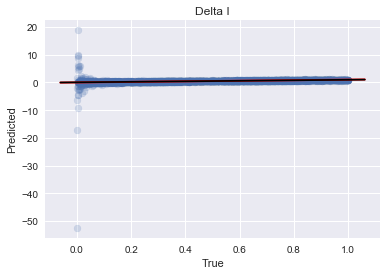

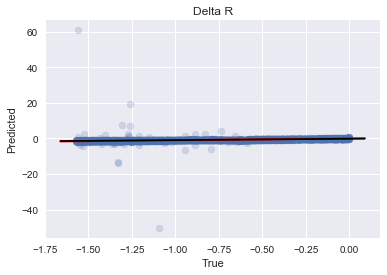

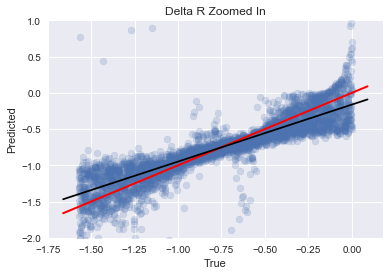

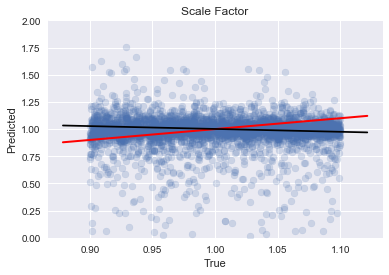

In [109]:
#Initialize and fit OLS model for deltaI 
model_OLS_I = sm.OLS(Y_train['deltaI'], X_train)
model_OLS_R = sm.OLS(Y_train['deltaR'], X_train)
model_OLS_sf = sm.OLS(Y_train['scale_factor'], X_train)

results_OLS_I = model_OLS_I.fit()
results_OLS_R = model_OLS_R.fit()
results_OLS_sf = model_OLS_sf.fit()

#Make predictions on testing data
predictions_OLS_I = results_OLS_I.predict(X_test) # make the predictions by the model
predictions_OLS_R = results_OLS_R.predict(X_test)
predictions_OLS_sf = results_OLS_sf.predict(X_test)

#print(results_OLS_I.summary())
#print(results_OLS_R.summary())

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y_test['deltaI'], predictions_OLS_I,'Delta I')
#ylim([-1,5])
plotSummary(Y_test['deltaR'], predictions_OLS_R, 'Delta R')
plotSummary(Y_test['deltaR'], predictions_OLS_R, 'Delta R Zoomed In')
ylim([-2,1])
plotSummary(Y_test['scale_factor'], predictions_OLS_sf, 'Scale Factor')
ylim([0,2])

OLS_deltaI_r2 =  r2_score(Y_test['deltaI'], predictions_OLS_I)
OLS_deltaR_r2 = r2_score(Y_test['deltaR'], predictions_OLS_R)
OLS_sf_r2 = r2_score(Y_test['scale_factor'], predictions_OLS_sf)


myResiduals(Y_test['deltaI'], predictions_OLS_I)
myResiduals(Y_test['deltaR'], predictions_OLS_R)
myResiduals(Y_test['scale_factor'], predictions_OLS_sf)

### Decision Tree

 
RMSE on test data: 0.034495377018959134 for  deltaI Depth 30
R^2 Score on test data: 0.9854276458885045 for deltaI Depth 30
 
RMSE on test data: 0.06296266190209687 for  deltaR Depth 30
R^2 Score on test data: 0.9808328052083003 for deltaR Depth 30
 
RMSE on test data: 0.07294143081693107 for  scale factor - DT
R^2 Score on test data: -0.5925678132488341 for scale factor - DT
 
Regression - Decision Tree -  Score:  0.9641062622762389 , using max depth of 30
 
Cross Validation Scores for regressor with max depth of  30  :  [0.96689241 0.9672543  0.95880797 0.96331194 0.9680009  0.9676809
 0.9679524  0.96982837 0.97155381 0.96809121]


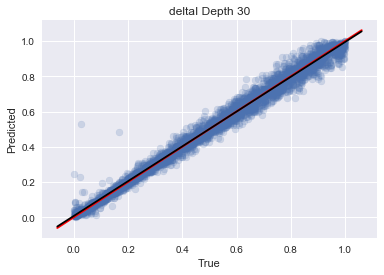

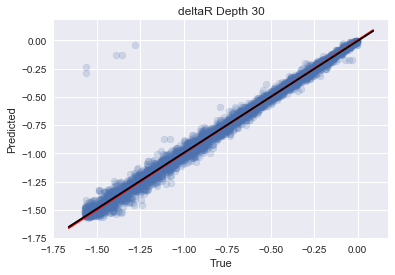

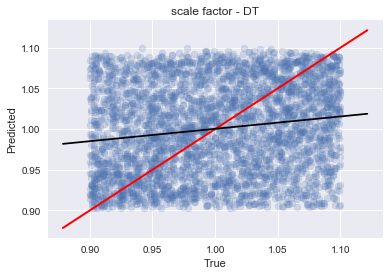

In [110]:
#Initialize the model
regr_DT = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2)

#Fit the model
regr_DT.fit(X_train, Y_train)


#Print the coefficients or importances

data1 = pd.DataFrame(regr_DT.feature_importances_.T, columns = ['Regr - DT']) 

data1.index = X_train.columns

#print(data1[data1['Regr - DT']>0.001])


#Use model to predict
y_pred_DT = regr_DT.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], y_pred_DT[:,0], 'deltaI Depth 30')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], y_pred_DT[:,1], 'deltaR Depth 30')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y_test['scale_factor'], y_pred_DT[:,2], 'scale factor - DT')

DT_deltaI_r2 =  r2_score(Y_test['deltaI'], y_pred_DT[:,0])
DT_deltaR_r2 = r2_score(Y_test['deltaR'], y_pred_DT[:,1])
DT_sf_r2 = r2_score(Y_test['scale_factor'], y_pred_DT[:,2])

print(' ')

#Trying to understand the scoring
print('Regression - Decision Tree -  Score: ', regr_DT.score(X_test,Y_test),', using max depth of 30')
print(' ')
regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print( 'Cross Validation Scores for regressor with max depth of ', regressor.max_depth, ' : ', cross_val_score(regressor, X, Y, cv=10))

## Random Forest


Score - Random Forest: 0.9802132728645359 for delta I/R 10
 
RMSE on test data: 0.02211341352836155 for  deltaI 10
R^2 Score on test data: 0.9940114800712758 for deltaI 10
 
RMSE on test data: 0.04733354378660989 for  deltaR 10
R^2 Score on test data: 0.9891674566291345 for deltaR 10
 
RMSE on test data: 0.05517960483690766 for  Scale Factor
R^2 Score on test data: 0.08860519282725643 for Scale Factor


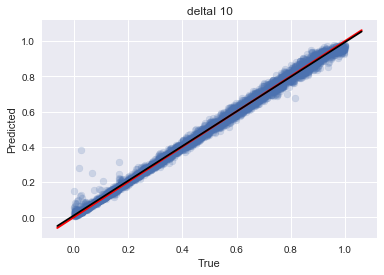

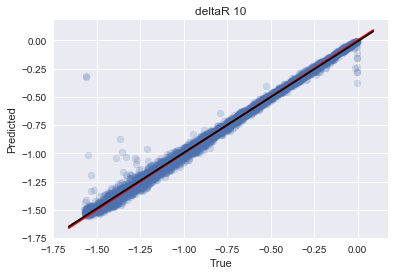

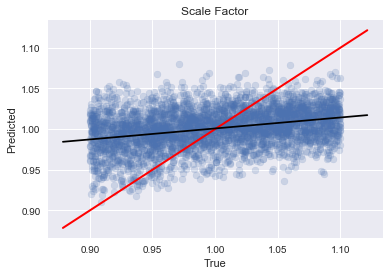

In [111]:
rs = 42
regr_RF = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF = regr_RF.fit(X_train, Y_train)

predict_RF = model_RF.predict(X_test)


importance_RF_10 = pd.Series(model_RF.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF.score(X_test, Y_test), 'for delta I/R 10')

plotSummary(Y_test['deltaI'], predict_RF[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], predict_RF[:,1], 'deltaR 10')
plotSummary(Y_test['scale_factor'], predict_RF[:,2], 'Scale Factor')

RF_deltaI_r2 =  r2_score(Y_test['deltaI'], predict_RF[:,0])
RF_deltaR_r2 = r2_score(Y_test['deltaR'], predict_RF[:,1])
RF_sf_r2 = r2_score(Y_test['scale_factor'], predict_RF[:,2])


## AdaBoost Random Forest

 
RMSE on test data: 0.019589870577199624 for  AdaBoost Delta I
R^2 Score on test data: 0.9953002900259138 for AdaBoost Delta I
 
RMSE on test data: 0.037774057226831644 for  AdaBoost Delta R
R^2 Score on test data: 0.9931011029661324 for AdaBoost Delta R
 
RMSE on test data: 0.055056755206532235 for  AdaBoost Scale Factor
R^2 Score on test data: 0.0926588600796392 for AdaBoost Scale Factor
Delta I AdaBoost Score: 0.9953002900259138
Delta R AdaBoost Score: 0.9931011029661324
Scale Factor AdaBoost Score: 0.0926588600796392


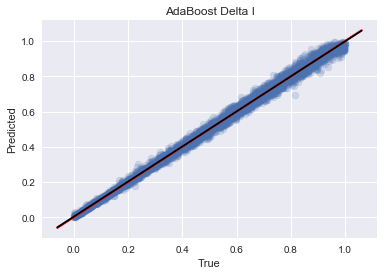

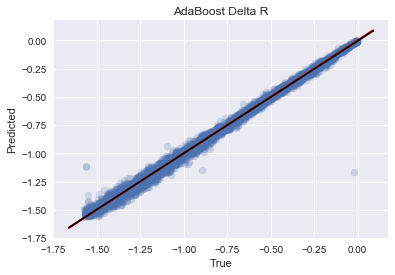

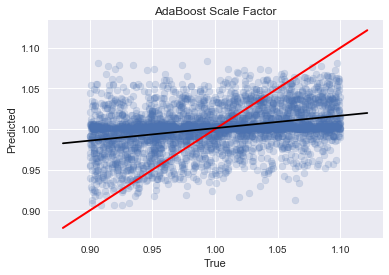

In [112]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_ABR = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

model_AB = regr_AB.fit(X_train, Y_train['deltaI'])
model_AB_R = regr_ABR.fit(X_train, Y_train['deltaR'])
model_AB_sf = regr_AB_sf.fit(X_train, Y_train['scale_factor'])

y_pred_AB1 = model_AB.predict(X_test)
y_pred_AB1_R = model_AB_R.predict(X_test)
y_pred_AB1_sf = model_AB_sf.predict(X_test)


plotSummary(Y_test['deltaI'], y_pred_AB1, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], y_pred_AB1_R, 'AdaBoost Delta R')
plotSummary(Y_test['scale_factor'], y_pred_AB1_sf, 'AdaBoost Scale Factor')

print('Delta I AdaBoost Score:', model_AB.score(X_test, Y_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_R.score(X_test, Y_test['deltaR']))
print('Scale Factor AdaBoost Score:', model_AB_sf.score(X_test, Y_test['scale_factor']))

AB_deltaI_r2 =  r2_score(Y_test['deltaI'], y_pred_AB1)
AB_deltaR_r2 = r2_score(Y_test['deltaR'], y_pred_AB1_R)
AB_sf_r2 = r2_score(Y_test['scale_factor'], y_pred_AB1_sf)

## Gradient Boosting Random Forest

In [84]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


regr_GB = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GBR = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)



In [85]:
model_GB = regr_GB.fit(X_train[1:3000], Y_train['deltaI'][1:3000])


In [86]:
model_GB_R = regr_GBR.fit(X_train[1:3000], Y_train['deltaR'][1:3000])


In [87]:
model_GB_sf = regr_GB_sf.fit(X_train[1:3000], Y_train['scale_factor'][1:3000])

 
RMSE on test data: 0.03917977580329444 for  GradientBoost Delta I
R^2 Score on test data: 0.9812011268538531 for GradientBoost Delta I
 
RMSE on test data: 0.062481042885509167 for  GradientBoost Delta R
R^2 Score on test data: 0.9811249141784655 for GradientBoost Delta R
 
RMSE on test data: 0.0705600894506452 for  GradientBoost Scale Factor
R^2 Score on test data: -0.4902791422516366 for GradientBoost Scale Factor
Delta I Gradient Boost Score: 0.981201126853853
Delta R Gradient Boost Score: 0.9811249141784655
Scale Factor Gradient Boost Score: -0.4902791422516366


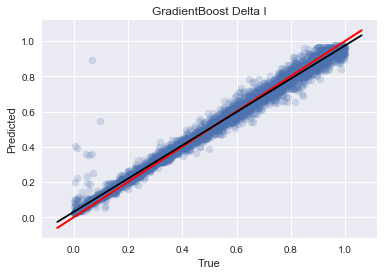

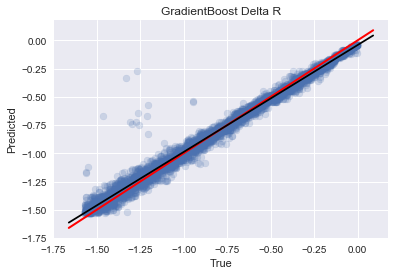

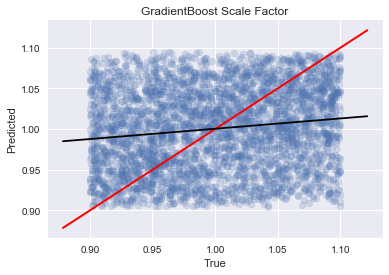

In [113]:
y_pred_GB1 = model_GB.predict(X_test)
y_pred_GB1_R = model_GB_R.predict(X_test)
y_pred_GB1_sf = model_GB_sf.predict(X_test)

plotSummary(Y_test['deltaI'], y_pred_GB1, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], y_pred_GB1_R, 'GradientBoost Delta R')
plotSummary(Y_test['scale_factor'], y_pred_GB1_sf, 'GradientBoost Scale Factor')

GB_deltaI_r2 =  r2_score(Y_test['deltaI'], y_pred_GB1)
GB_deltaR_r2 = r2_score(Y_test['deltaR'], y_pred_GB1_R)
GB_sf_r2 = r2_score(Y_test['scale_factor'], y_pred_GB1_sf)

print('Delta I Gradient Boost Score:', model_GB.score(X_test, Y_test['deltaI']))
print('Delta R Gradient Boost Score:', model_GB_R.score(X_test, Y_test['deltaR']))
print('Scale Factor Gradient Boost Score:', model_GB_sf.score(X_test, Y_test['scale_factor']))

## Testing the Models on the Experimental Data



In [96]:
# Load experimental data
exp_data = pd.read_csv('Training_Data/Graphene/ES_AG_Exp_data.csv', header = None, names = ['deltaI', 'deltaR']+energy_names+energy_names)
exp_data = exp_data.drop(['deltaI', 'deltaR'], axis = 1)
display(exp_data)

C:\Users\emory\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV.1,E_484_mV.1,E_486_mV.1,E_488_mV.1,E_490_mV.1,E_492_mV.1,E_494_mV.1,E_496_mV.1,E_498_mV.1,E_500_mV.1
0,0.74095,1.0937,0.98544,1.0485,1.0155,1.0431,1.0318,1.0431,1.0379,1.0407,...,1.0368,1.0407,1.0411,1.0484,1.0385,1.0555,1.0324,1.072,1.0134,1.128


In [97]:


pred_phase_OLS_R = results_OLS_R.predict(exp_data)
pred_phase_OLS_I = results_OLS_I.predict(exp_data)
pred_scale_factor_OLS = results_OLS_sf.predict(exp_data)

pred_phase_DT = regr_DT.predict(exp_data)

pred_phase_RF = regr_RF.predict(exp_data)

pred_phase_AB_R = model_AB_R.predict(exp_data)
pred_phase_AB_I = model_AB.predict(exp_data)
pred_sf_AB = model_AB_sf.predict(exp_data)

pred_phase_GB_I = model_GB.predict(exp_data)
pred_phase_GB_R = model_GB_R.predict(exp_data)
pred_sf_GB = model_GB_sf.predict(exp_data)

In [98]:
predictedPhases = pd.DataFrame(pred_phase_DT, columns = ['deltaI', 'deltaR', 'scale_factor'], index = ['Decision Tree'])

predictedPhases.loc['OLS'] = (pred_phase_OLS_I[0], pred_phase_OLS_R[0], pred_scale_factor_OLS[0])
predictedPhases.loc['Random Forest'] = pred_phase_RF[0]
predictedPhases.loc['AdaBoost'] = (pred_phase_AB_I[0], pred_phase_AB_R[0], pred_sf_AB[0])
predictedPhases.loc['Gradient Boosting'] = (pred_phase_GB_I[0], pred_phase_GB_R[0], pred_sf_GB[0])

predictedPhases

,deltaI,deltaR,scale_factor
Decision Tree,0.453595,-1.550350,0.903925
OLS,-22.555328,11.332434,16.248422
Random Forest,0.339292,-1.541393,0.937020
AdaBoost,0.328840,-1.487200,1.017500
Gradient Boosting,0.255864,-1.332609,1.087435


In [122]:
R2_scores = [('OLS', OLS_deltaI_r2, OLS_deltaR_r2, OLS_sf_r2 ),
         ('Decision Tree', DT_deltaI_r2, DT_deltaR_r2, DT_sf_r2 ),
         ('Random Forest', RF_deltaI_r2, RF_deltaR_r2, RF_sf_r2), 
           ('Adaboost', AB_deltaI_r2, AB_deltaR_r2, AB_sf_r2),
            ('Gradient Boost', GB_deltaI_r2, GB_deltaR_r2, GB_sf_r2)]
labels = ['Method', 'deltaI', 'deltaR', 'Scale Factor']
R2_summary = pd.DataFrame.from_records(R2_scores, columns=labels)
print("R Squared Scores")
R2_summary.head()

R Squared Scores


,Method,deltaI,deltaR,Scale Factor
0,OLS,-13.166851,-9.132107,-525.997450
1,Decision Tree,0.985428,0.980833,-0.592568
2,Random Forest,0.994011,0.989167,0.088605
3,Adaboost,0.995300,0.993101,0.092659
4,Gradient Boost,0.981201,0.981125,-0.490279


## TRAINING A SECOND SET OF MODELS WITH FIRST PREDICTED SCALE FACTOR

Used a scale factor of 0.964 when generating training data

In [24]:
#Load the training data

#energy = (pd.read_csv('HexagonBias_v3.csv', header=None)*1000).round().astype(int)
energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)

energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]

col_names = ['deltaI', 'deltaR']+ energy_names

#data = pd.read_csv('HexagonTrainingData052818_specPoints.csv', header = None, names = col_names)
#data = pd.read_csv('HexagonTrainingData060518_v3.csv', header = None, names = col_names)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData060618_v5.csv', header = None, names = col_names)


data2.head()

X2 = data2.drop(['deltaI', 'deltaR'], axis = 1)
Y2 = data2[['deltaI', 'deltaR']]

ts1 = 0.3
rs1 = 42

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1 )
data2.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.147980,0.146410,0.140510,0.137420,0.136640,0.137930,0.141230,0.146790,0.154270,...,1.1335,1.1490,1.16190,1.17160,1.17770,1.1793,1.17680,1.17010,1.15940,1.14460
1,0.12699,-0.136070,0.248730,0.250010,0.255530,0.265280,0.279410,0.298410,0.323420,0.354720,...,0.9333,0.9257,0.91819,0.91091,0.90379,0.8969,0.89025,0.88397,0.87806,0.87245
2,0.63236,-1.417600,0.078366,0.074908,0.073144,0.072517,0.073092,0.074697,0.077583,0.081380,...,1.0250,1.0951,1.17190,1.25340,1.33730,1.4204,1.49910,1.56760,1.62160,1.65610
3,0.27850,-0.711760,0.058813,0.057001,0.056270,0.056455,0.057543,0.059512,0.062651,0.066466,...,1.9902,1.9255,1.82300,1.69600,1.55880,1.4189,1.28570,1.16340,1.05340,0.95498
4,0.95751,-0.055153,0.142160,0.136130,0.132890,0.131890,0.132890,0.135840,0.140930,0.147850,...,1.1125,1.1322,1.15030,1.16560,1.17780,1.1858,1.18970,1.18900,1.18400,1.17430


### DECISION TREE - JUST PHASE

 
RMSE on test data: 0.010578751086137601 for  deltaI Depth 30
R^2 Score on test data: 0.9986689299668658 for deltaI Depth 30
 
RMSE on test data: 0.010693784405371654 for  deltaR Depth 30
R^2 Score on test data: 0.9994430275651497 for deltaR Depth 30
 
Regression - Decision Tree -  Score:  0.9992181356778069 , using max depth of 30
 
Cross Validation Scores for regressor with max depth of  30  :  [0.99904924 0.99910035 0.99904711 0.99905938 0.9990457  0.9991018
 0.99860326 0.99910287 0.99914475 0.99910185]


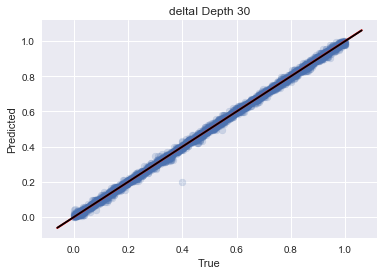

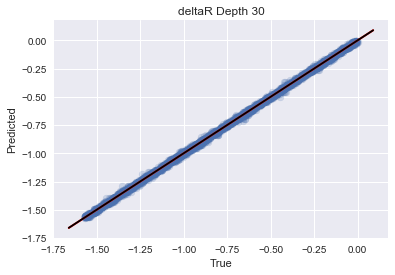

In [25]:
#Initialize the model
regr_DT_2 = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2)

#Fit the model
regr_DT_2.fit(X2_train, Y2_train)


#Print the coefficients or importances

data1 = pd.DataFrame(regr_DT_2.feature_importances_.T, columns = ['Regr - DT']) 

data1.index = X2_train.columns

#print(data1[data1['Regr - DT']>0.001])


#Use model to predict
y_pred_DT_2 = regr_DT_2.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], y_pred_DT_2[:,0], 'deltaI Depth 30')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], y_pred_DT_2[:,1], 'deltaR Depth 30')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y_test['scale_factor'], y_pred_DT[:,2], 'scale factor - DT')

print(' ')

#Trying to understand the scoring
print('Regression - Decision Tree -  Score: ', regr_DT_2.score(X2_test,Y2_test),', using max depth of 30')
print(' ')
regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print( 'Cross Validation Scores for regressor with max depth of ', regressor.max_depth, ' : ', cross_val_score(regressor, X2, Y2, cv=10))

### RANDOM FOREST - JUST PHASE


Score - Random Forest: 0.9998733596759214 for delta I/R 10
 
RMSE on test data: 0.004478631321149679 for  deltaI 10
R^2 Score on test data: 0.9997614262070802 for deltaI 10
 
RMSE on test data: 0.004073185076809497 for  deltaR 10
R^2 Score on test data: 0.9999191948312431 for deltaR 10


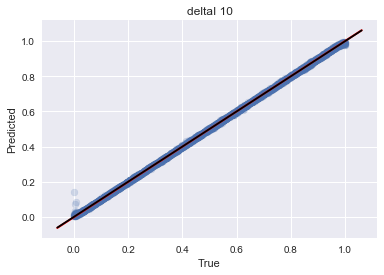

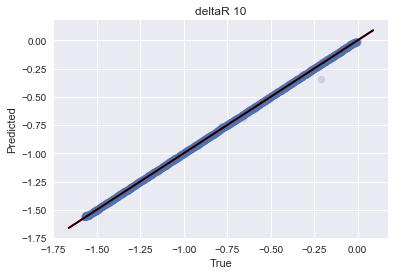

In [26]:
rs = 42
regr_RF_2 = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_2 = regr_RF_2.fit(X2_train, Y2_train)

predict_RF_2 = model_RF_2.predict(X2_test)


importance_RF_10_2 = pd.Series(model_RF_2.feature_importances_, index = X2_train.columns)

print('')
print('Score - Random Forest:' , model_RF_2.score(X2_test, Y2_test), 'for delta I/R 10')

plotSummary(Y2_test['deltaI'], predict_RF_2[:,0], 'deltaI 10')
plotSummary(Y2_test['deltaR'], predict_RF_2[:,1], 'deltaR 10')


## TEST EXPERIMENTAL DATA ON SECOND VERSIONS OF MODELS


In [27]:
# Load the experimental data
exp_data = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData060618_v3.csv', header = None, names = energy_names)


pred_phase_DT_2 = regr_DT_2.predict(exp_data)

pred_phase_RF_2 = regr_RF_2.predict(exp_data)

predictedPhases = pd.DataFrame(pred_phase_DT_2, columns = ['deltaI', 'deltaR'], index = ['Decision Tree'])

predictedPhases.loc['Random Forest'] = pred_phase_RF_2[0]

print(predictedPhases)
predictedPhases.mean()

                 deltaI    deltaR
Decision Tree  0.164965 -0.089918
Random Forest  0.180288 -0.101343


deltaI    0.172626
deltaR   -0.095630
dtype: float64